In [97]:
#Import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
# Read the CSV file
data = pd.read_csv('Lifespan/companyDrug/speeds_and_coordinates_20241016_4_updated.csv')

In [99]:
# Display the first few rows of the dataset
print(data.head())
#Summary of data
print(data.describe())

   Frame       Speed           X           Y  Changed Pixels
0      1   14.152425  476.356932  487.840708             460
1      2   21.822664  419.305000  511.537500             494
2      3   22.484239  430.031250  509.536318             200
3      4  120.411300  453.283636  505.876364             310
4      5  103.131087  414.000000  551.500000             200
              Frame         Speed             X             Y  Changed Pixels
count  75593.000000  75593.000000  74855.000000  74855.000000    75593.000000
mean    5400.000000      1.420182    347.420578    497.622615       23.145662
std     3117.423385     11.178094    121.705676    129.644571       42.538445
min        1.000000      0.000000    124.005291    159.162088        0.000000
25%     2700.000000      0.000000    249.765571    390.323443        0.000000
50%     5400.000000      0.275513    336.299479    513.923404        8.000000
75%     8100.000000      1.076040    425.747680    632.201238       30.000000
max    107

In [100]:
#Correct Frame numbers --> now all frames are unique, use as ID column
data["continuous_frames"] = data.index + 1


In [101]:
print(data.shape)
print(f"Total time recorded: {round(data.shape[0]*2/3600,3)} hours")

(75593, 6)
Total time recorded: 41.996 hours


In [102]:
#Add Euclidean Speed to the next column
data['euclidean_speed'] = np.sqrt((data['X'].diff())**2 + (data['Y'].diff())**2) * 2
data['euclidean_speed'] = data['euclidean_speed'].shift(-1)

data['speed_diff'] = data['euclidean_speed'] - data['Speed']
data['speed_diff'] = np.where(abs(data['speed_diff']) < 0.01, 0, data['speed_diff'])

In [103]:
# print(data[['euclidean_speed', 'Speed', 'speed_diff']])
non_zero_count = (data['speed_diff'] != 0).sum()

print(f"Number of rows where speed_diff is not 0: {non_zero_count}")

Number of rows where speed_diff is not 0: 1172


In [104]:
# Step 1: Check for "no significant movement" with a tolerance of 0.5
tolerance_movement = 0.5
# data['no_movement'] = (data['X'].diff().fillna(0).abs() < tolerance_movement) & (data['Y'].diff().fillna(0).abs() < tolerance_movement)
tolerance_speed = 0.1
data['no_movement'] = data['Speed'].abs() < tolerance_speed

# Step 2: Count consecutive no-movement frames
# Use a cumulative counter that resets when movement is detected
data['no_movement_count'] = data['no_movement'].cumsum() - data['no_movement'].cumsum().where(~data['no_movement']).ffill().fillna(0).astype(int)

# Step 3: Identify when no movement reaches the threshold
threshold = 153
data['dead'] = data['no_movement_count'] >= threshold

# Step 4: Record the first row where the worm is declared dead
dead_row = data[data['dead']].index.min()

if pd.notna(dead_row):
    print(f"The worm is declared dead at row index: {dead_row}")
    # Display relevant columns for verification
    print(data[['Frame', 'X', 'Y', 'Changed Pixels', 'Speed', 'no_movement', 'no_movement_count', 'dead']].iloc[max(dead_row - 3, 0):min(dead_row + 3, len(data) - 1)])
else:
    print("The worm never reaches the dead threshold.")



The worm is declared dead at row index: 4814
      Frame           X           Y  Changed Pixels     Speed  no_movement  \
4811   4812         NaN         NaN               0  0.000000         True   
4812   4813         NaN         NaN               0  0.000000         True   
4813   4814         NaN         NaN               0  0.000000         True   
4814   4815         NaN         NaN              13  0.000000         True   
4815   4816  334.000000  628.000000              13  1.233171        False   
4816   4817  333.384615  628.038462               7  0.408005        False   

      no_movement_count   dead  
4811                150  False  
4812                151  False  
4813                152  False  
4814                153   True  
4815                  0  False  
4816                  0  False  


In [105]:
from exploration_trial import worm_death

# Iterate over all CSV files in the "Lifespan/companyDrug" directory
directory_path = "Lifespan/companyDrug"

worm_death_dict = {}

for file in os.listdir(directory_path):
    if file.endswith(".csv"):
        filepath = os.path.join(directory_path, file)
        
        # Extract worm ID from the filename
        worm_id = file.split("_")[4]  # Adjust the index based on the filename format
        
        # Call the worm_death function for each file
        dead_row = worm_death(filepath)
    
        worm_death_dict[worm_id] = [dead_row, 1] #1 indicates drug
        
        if pd.notna(dead_row):
            print(f"Worm {worm_id} is declared dead at row index {dead_row}.")
        else:
            print(f"Worm {worm_id} never reaches the dead threshold.")

directory_path = "Lifespan/control"
for file in os.listdir(directory_path):
    if file.endswith(".csv"):
        filepath = os.path.join(directory_path, file)
        
        # Extract worm ID from the filename
        worm_id = file.split("_")[4]  # Adjust the index based on the filename format
        
        # Call the worm_death function for each file
        dead_row = worm_death(filepath)
    
        worm_death_dict[worm_id] = [dead_row, 0] #0 indicates no drug
        
        if pd.notna(dead_row):
            print(f"Worm {worm_id} is declared dead at row index {dead_row}.")
        else:
            print(f"Worm {worm_id} never reaches the dead threshold.")

Worm 24 never reaches the dead threshold.
Worm 3 is declared dead at row index 4761.
Worm 6 is declared dead at row index 1156.
Worm 21 is declared dead at row index 3578.
Worm 22 never reaches the dead threshold.
Worm 5 never reaches the dead threshold.
Worm 2 is declared dead at row index 842.
Worm 25 is declared dead at row index 7154.
Worm 26 is declared dead at row index 45994.
Worm 1 never reaches the dead threshold.
Worm 4 is declared dead at row index 99.
Worm 23 is declared dead at row index 25353.
Worm 16 is declared dead at row index 5826.
Worm 31 is declared dead at row index 99.
Worm 34 is declared dead at row index 13281.
Worm 13 is declared dead at row index 998.
Worm 32 is declared dead at row index 99.
Worm 15 never reaches the dead threshold.
Worm 12 is declared dead at row index 7071.
Worm 35 is declared dead at row index 852.
Worm 14 is declared dead at row index 99.
Worm 33 is declared dead at row index 1753.
Worm 36 is declared dead at row index 59668.
Worm 11 is 

In [106]:
print(worm_death_dict)

{'24': [nan, 1], '3': [4761, 1], '6': [1156, 1], '21': [3578, 1], '22': [nan, 1], '5': [nan, 1], '2': [842, 1], '25': [7154, 1], '26': [45994, 1], '1': [nan, 1], '4': [99, 1], '23': [25353, 1], '16': [5826, 0], '31': [99, 0], '34': [13281, 0], '13': [998, 0], '32': [99, 0], '15': [nan, 0], '12': [7071, 0], '35': [852, 0], '14': [99, 0], '33': [1753, 0], '36': [59668, 0], '11': [2798, 0]}


## December 5th 

Advaith: speed variability, stdev, rolling average stdev, euclidean speed (graph over time), time (seconds), ask questions on Slack re. worm age. Look into ATRs


In [107]:
#time
# 2x + (mod(x-1 / 900) 5.5 * 3600)

def calculate_time_units(frames):
    """
    Calculate elapsed time in seconds, minutes, hours, and days for each frame.

    Args:
    frames (array-like): Continuous frame numbers.

    Returns:
    pandas.DataFrame: A DataFrame with columns for seconds, minutes, hours, and days.

    To run:
    time_columns = calculate_time_units(data['continuous_frames'])
    data = pd.concat([data, time_columns], axis=1)
    """
    frames = np.array(frames)  # Ensure input is a numpy array for vectorized computation
    recording_period = 900  # Frames in a recording session (30 minutes)
    recording_duration = 2 * recording_period  # Time in seconds for one session (30 minutes)
    break_duration = 5.5 * 3600  # 5.5 hours in seconds

    # Calculate elapsed time in seconds
    elapsed_seconds = (
        2 * (frames % recording_period) +  # Time within the current recording session
        (frames // recording_period) * (recording_duration + break_duration)  # Time from skipped intervals
    )
    
    # Convert to other units
    elapsed_minutes = elapsed_seconds / 60
    elapsed_hours = elapsed_minutes / 60
    elapsed_days = elapsed_hours / 24

    # Return as a DataFrame
    return pd.DataFrame({
        'time_seconds': elapsed_seconds,
        'time_minutes': elapsed_minutes,
        'time_hours': elapsed_hours,
        'time_days': elapsed_days
    })



In [108]:
time_columns = calculate_time_units(data['continuous_frames'])
data = pd.concat([data, time_columns], axis=1)
print(data)

       Frame       Speed           X           Y  Changed Pixels  \
0          1   14.152425  476.356932  487.840708             460   
1          2   21.822664  419.305000  511.537500             494   
2          3   22.484239  430.031250  509.536318             200   
3          4  120.411300  453.283636  505.876364             310   
4          5  103.131087  414.000000  551.500000             200   
...      ...         ...         ...         ...             ...   
75588  10795    0.227977  252.201258  413.493711               2   
75589  10796    0.232661  252.094937  413.534810               4   
75590  10797    0.246152  251.984076  413.570064               8   
75591  10798    0.619326  251.866883  413.532468              26   
75592  10799    1.199099  251.673203  413.290850              49   

       continuous_frames  euclidean_speed  speed_diff  no_movement  \
0                      1       123.555023  109.402598        False   
1                      2        21.822664  

In [109]:
#speed variability
def calculate_speed_variability(data, interval):
    """
    Calculate speed variability over specified intervals.

    Args:
    data (pd.DataFrame): DataFrame containing at least the 'euclidean_speed' column.
    interval (int): Number of rows (frames) per interval.

    Returns:
    pd.DataFrame: DataFrame with new columns:
                  - 'std_speed': Standard deviation of speed in each interval
                  - 'mean_speed': Mean speed in each interval
                  - 'speed_variability': Ratio of std to mean in each interval
    """
    # Validate input
    if 'euclidean_speed' not in data.columns:
        raise ValueError("The DataFrame must contain a column named 'euclidean_speed'.")

    # Calculate rolling statistics based on intervals
    rolling_std = data['euclidean_speed'].rolling(window=interval, min_periods=1).std()
    rolling_mean = data['euclidean_speed'].rolling(window=interval, min_periods=1).mean()

    # Assign computed values to new columns
    data['std_speed'] = rolling_std
    data['mean_speed'] = rolling_mean
    data['speed_variability'] = data['std_speed'] / data['mean_speed']

    # Propagate interval values to all rows within the interval
    for col in ['std_speed', 'mean_speed', 'speed_variability']:
        data[col] = data[col].shift(-interval + 1).fillna(method='bfill')
        
    return data

def plot_data_over_interval(x, y, interval, x_label, y_label):
    """
    Plot speed variability over time.

    Args:
    data (pd.DataFrame): DataFrame containing 'speed_variability' and 'time'.
    interval (int): Interval used for calculations (used for graphing notes).
    """
    plt.figure(figsize=(10, 6))
    # Plot speed variability against time
    plt.plot(x, y, label=y_label, color='blue', linewidth=1.5)
    plt.title(f"{y_label} Over Time (Interval = {interval} frames)")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.legend()
    plt.grid()
    plt.show()


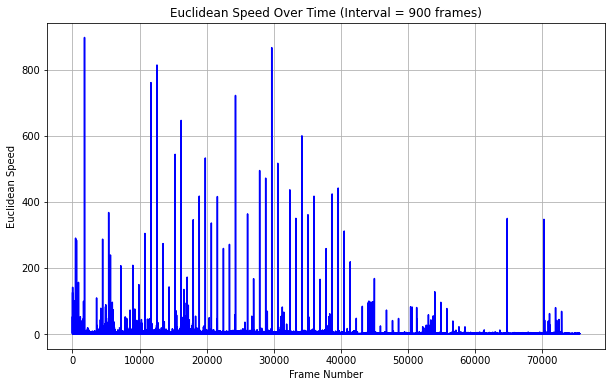

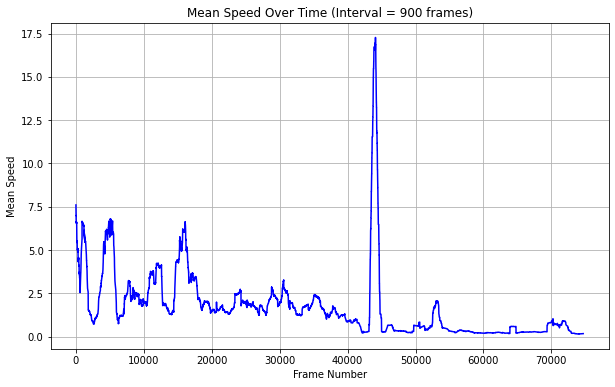

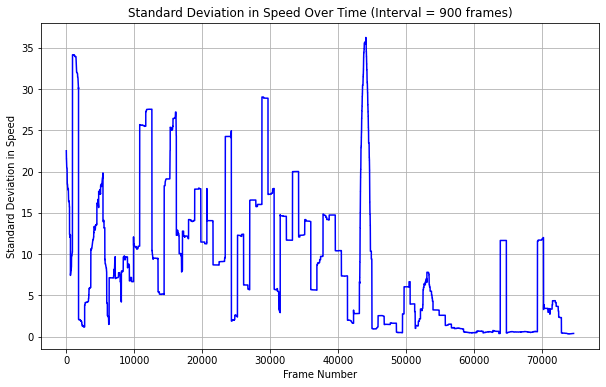

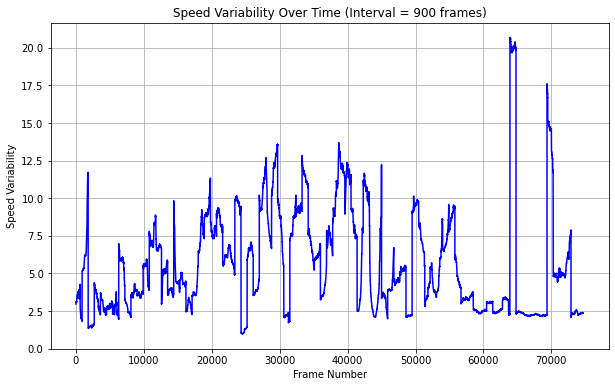

In [110]:
# Define a global variable for the interval
INTERVAL = 900  # Default interval; can be changed globally

data_updated = calculate_speed_variability(data, interval=INTERVAL)

# Check the result
# print(data_updated.head(20))

# Plot speed variability
plot_data_over_interval(data_updated.index, data_updated['euclidean_speed'], x_label = "Frame Number", y_label="Euclidean Speed", interval=INTERVAL)
plot_data_over_interval(data_updated.index, data_updated['mean_speed'], x_label = "Frame Number", y_label="Mean Speed", interval=INTERVAL)
plot_data_over_interval(data_updated.index, data_updated['std_speed'], x_label = "Frame Number", y_label="Standard Deviation in Speed", interval=INTERVAL)
plot_data_over_interval(data_updated.index, data_updated['speed_variability'], x_label = "Frame Number", y_label="Speed Variability", interval=INTERVAL)



In [122]:
import matplotlib.pyplot as plt

def plot_histogram_over_interval(x, y, interval, x_label, y_label, bin_label="Interval Start"):
    """
    Plot a histogram of data over specified intervals.

    Args:
    x (pd.Series or np.ndarray): The x-axis values (e.g., time).
    y (pd.Series or np.ndarray): The y-axis values (e.g., speed variability).
    interval (int): Number of rows (frames) per interval.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    bin_label (str): Label for histogram bins.
    """
    # Group data into intervals
    interval_indices = np.arange(0, len(x), interval)  # Start of each interval
    grouped_x = x[interval_indices]
    grouped_y = y[interval_indices]

    plt.figure(figsize=(10, 6))
    plt.bar(grouped_x, grouped_y, width=interval, align='center', color='blue', edgecolor='black')
    plt.title(f"Histogram of {y_label} Over Intervals")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


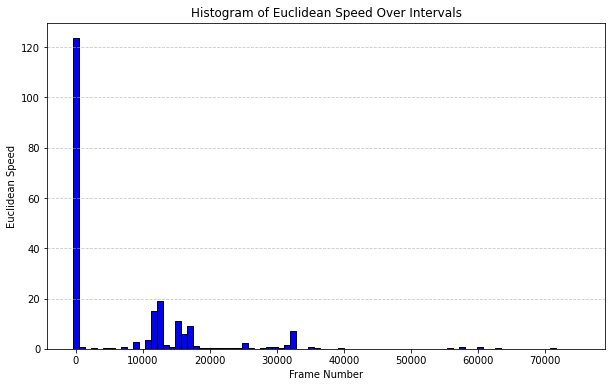

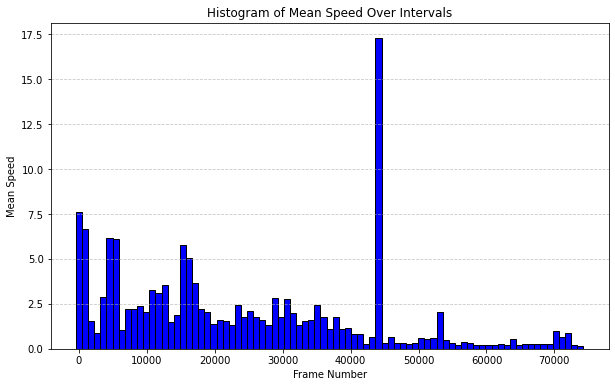

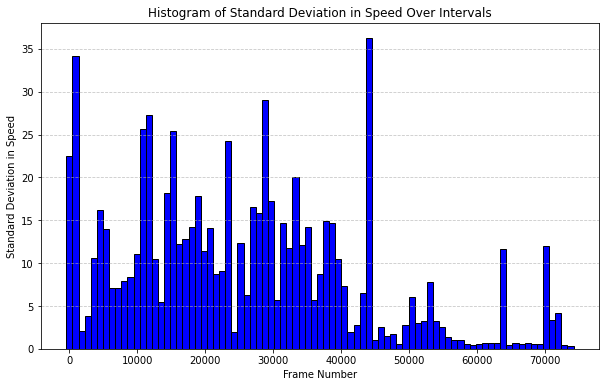

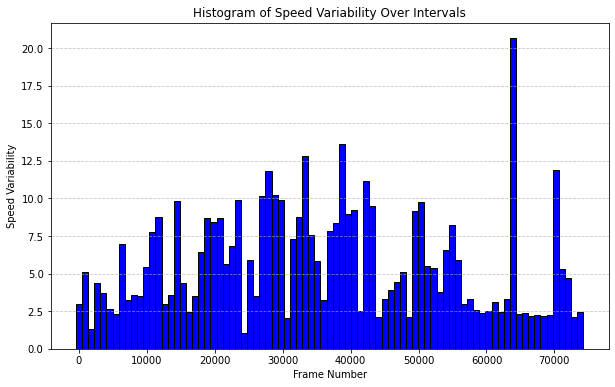

In [123]:
# Plot speed variability
plot_histogram_over_interval(data_updated.index, data_updated['euclidean_speed'], x_label = "Frame Number", y_label="Euclidean Speed", interval=INTERVAL)
plot_histogram_over_interval(data_updated.index, data_updated['mean_speed'], x_label = "Frame Number", y_label="Mean Speed", interval=INTERVAL)
plot_histogram_over_interval(data_updated.index, data_updated['std_speed'], x_label = "Frame Number", y_label="Standard Deviation in Speed", interval=INTERVAL)
plot_histogram_over_interval(data_updated.index, data_updated['speed_variability'], x_label = "Frame Number", y_label="Speed Variability", interval=INTERVAL)
